# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [11]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [12]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Create training set and define training dataloader
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create test set and define test dataloader
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

The transforms chosen for the MNIST dataset are ToTensor() and Normalize(). The ToTensor() transform converts the PIL image or NumPy array to a PyTorch tensor with values ranging from 0 to 1. The Normalize() transform normalizes the tensor image with mean and standard deviation. In this case, the mean and standard deviation values of 0.1307 and 0.3081 are used, which are the global mean and standard deviation of the MNIST dataset.

These transforms are important preprocessing steps because they help to standardize the input data, making it easier for the neural network to learn from the data. Normalizing the data can also help to improve the training speed and performance of the neural network.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [13]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

9


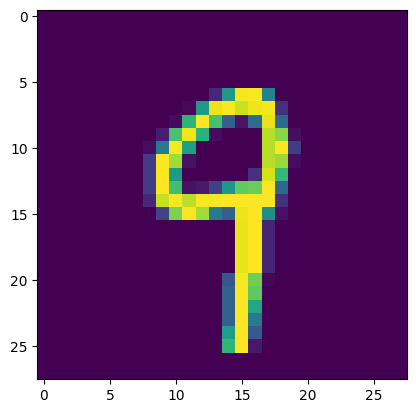

6


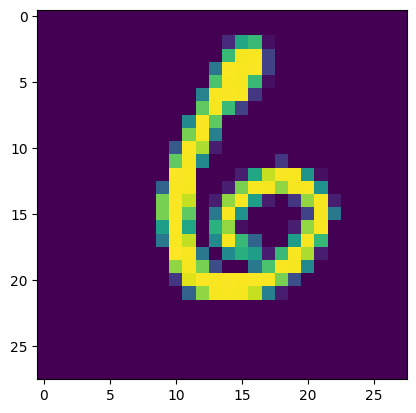

8


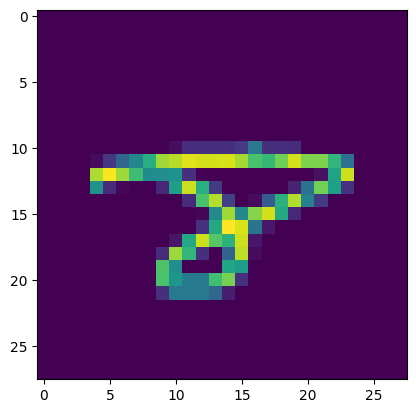

7


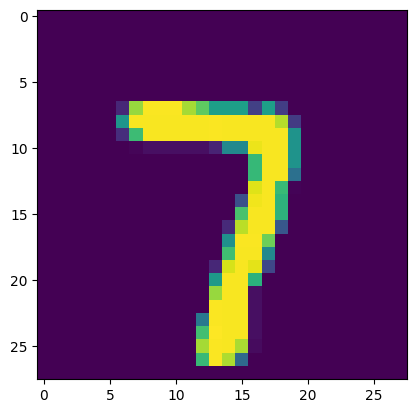

6


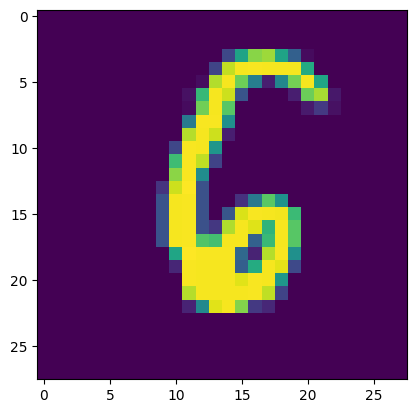

In [14]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
# Define the class for your neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [17]:
# Choose an optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Choose a loss function
criterion = nn.CrossEntropyLoss()

# # Instantiate the model
model = Net()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [18]:
num_epochs = 10

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 28.63% training loss: 0.34685
Epoch 1 validation accuracy: 30.12% validation loss: 0.18126
Epoch 2 training accuracy: 30.33% training loss: 0.16954
Epoch 2 validation accuracy: 30.58% validation loss: 0.13750
Epoch 3 training accuracy: 30.71% training loss: 0.12958
Epoch 3 validation accuracy: 30.91% validation loss: 0.10374
Epoch 4 training accuracy: 30.97% training loss: 0.10227
Epoch 4 validation accuracy: 30.74% validation loss: 0.12220
Epoch 5 training accuracy: 31.07% training loss: 0.09238
Epoch 5 validation accuracy: 30.90% validation loss: 0.10213
Epoch 6 training accuracy: 31.18% training loss: 0.08083
Epoch 6 validation accuracy: 30.88% validation loss: 0.10770
Epoch 7 training accuracy: 31.26% training loss: 0.07186
Epoch 7 validation accuracy: 30.96% validation loss: 0.09786
Epoch 8 training accuracy: 31.36% training loss: 0.06389
Epoch 8 validation accuracy: 31.13% validation loss: 0.08694
Epoch 9 training accuracy: 31.37% training loss: 0.05990

In [19]:
# ## YOUR CODE HERE ##
# # Set the device to run on: GPU if available, else CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Number of epochs to train for
# num_epochs = 5

# # List to store the average loss at each epoch
# epoch_losses = []

# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader):
#         # Get the inputs and labels
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Backward pass
#         loss.backward()
#         optimizer.step()

#         # Update the running loss
#         running_loss += loss.item()

#         # Print the average loss every 250 mini-batches
#         if (i + 1) % 250 == 0:
#             print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / (i + 1)}')

#     # Calculate and store the average loss for this epoch
#     epoch_loss = running_loss / len(train_loader)
#     epoch_losses.append(epoch_loss)
#     print(f'Epoch {epoch + 1} loss: {epoch_loss}')


Plot the training loss (and validation loss/accuracy, if recorded).

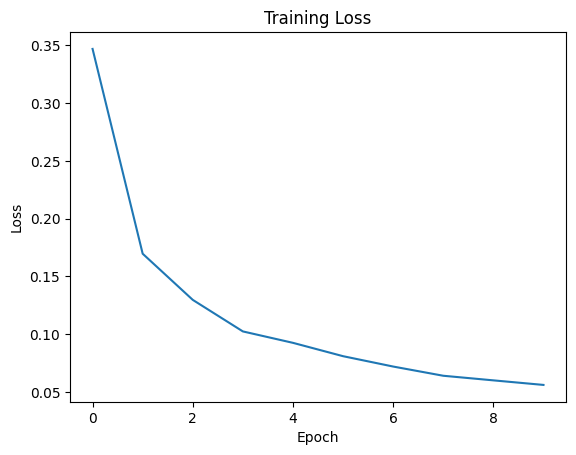

In [20]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further!
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [25]:
## YOUR CODE HERE ##
correct = 0
total = 0

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for data in test_loader:
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # Update the total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')


Accuracy: 94.53%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [26]:
# Define the class for your neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(32 * 32 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.8)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Instantiate the model
net = Net()

## Saving your model
Using `torch.save`, save your model for future loading.

In [27]:
## YOUR CODE HERE ##
# Specify the path to save the model
model_path = './mnist_model.pth'

# Save the model
torch.save(model.state_dict(), model_path)
